This notebook handles:

- Loading vectorized matrices and vectorizers from the vectorization phase.
- Determining optimal number of topics using coherence scores.
- Applying topic modeling: LDA (with Count Matrix via Gensim for efficiency) and NMF (with TF-IDF Matrix via scikit-learn).
- Evaluating models (coherence scores, top words per topic).
- Visualizing topics (pyLDAvis for LDA, word clouds for NMF topics).
- Saving models and results for the reflection/finalization phase.

We use Gensim for LDA (multicore support for large data) and coherence calculation. scikit-learn for NMF. Hyperparameters are tuned based on coherence scores over a range of topic numbers (e.g., 5-20) to identify the optimal number. For the large dataset (~242k documents), we use sparse formats and may subsample for coherence tuning if memory is an issue.

## 1. Import Libraries

In [18]:
import joblib
import numpy as np
import pandas as pd
from scipy.sparse import load_npz
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import LdaMulticore
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
import random
pyLDAvis.enable_notebook()

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="gensim.topic_coherence.direct_confirmation_measure")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="gensim.topic_coherence.indirect_confirmation_measure")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## 2. Load Vectorized Data

In [2]:
# Load vectorizers
tfidf_vectorizer = joblib.load('../data/processed/tfidf_vectorizer.pkl')
count_vectorizer = joblib.load('../data/processed/count_vectorizer.pkl')

# Load matrices (sparse)
tfidf_matrix = load_npz('../data/processed/tfidf_matrix.npz')
count_matrix = load_npz('../data/processed/count_matrix.npz')

# Get feature names (vocabulary)
tfidf_features = tfidf_vectorizer.get_feature_names_out()
count_features = count_vectorizer.get_feature_names_out()

# For Gensim LDA: Convert count matrix to Corpus and Dictionary
corpus = Sparse2Corpus(count_matrix, documents_columns=False)
dictionary = Dictionary.from_corpus(corpus, id2word=dict(enumerate(count_features)))

# Inspect
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Count Matrix Shape: {count_matrix.shape}")
print(f"Vocabulary Size: {len(dictionary)}")

# Load processed texts and tokenize using vectorizer's analyzer for consistency
processed_df = pd.read_csv('../data/processed/processed_complaints.csv', usecols=['processed_text'])
processed_df['processed_text'] = processed_df['processed_text'].fillna('')
analyzer = count_vectorizer.build_analyzer()
texts = [analyzer(text) for text in processed_df['processed_text']]

# Filter non-empty token lists
texts = [t for t in texts if len(t) > 0]
print(f"Number of non-empty tokenized texts: {len(texts)}")

# Subsample for coherence computation (e.g., 10k for speed)
random.seed(42)
texts_sample = random.sample(texts, min(10000, len(texts)))

TF-IDF Matrix Shape: (242348, 1617)
Count Matrix Shape: (242348, 1617)
Vocabulary Size: 1617
Number of non-empty tokenized texts: 242348


## 3. Determine Optimal Number of Topics
We compute coherence scores (CV metric) for a range of topic numbers to find the optimal k.

### a) For LDA (using Gensim)

In [3]:
# Function to compute coherence for LDA
def compute_lda_coherence_values(corpus, dictionary, texts, k_range, coherence_type='c_v'):
    coherence_values = []
    for k in k_range:
        try:
            lda_model = LdaMulticore(corpus=corpus, num_topics=k, id2word=dictionary, passes=5, workers=4, random_state=42)
            coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence=coherence_type)
            score = coherence_model.get_coherence()
            coherence_values.append(score)
            print(f"Num Topics: {k}, Coherence ({coherence_type}): {score}")
        except Exception as e:
            print(f"Error for k={k}: {e}")
            coherence_values.append(np.nan)
    return coherence_values

Num Topics: 4, Coherence (c_v): 0.5338602518447679
Num Topics: 6, Coherence (c_v): 0.5147614774909656
Num Topics: 8, Coherence (c_v): 0.4881576604778171
Num Topics: 10, Coherence (c_v): 0.46233554823679696
Num Topics: 12, Coherence (c_v): 0.44666277901356416
Num Topics: 14, Coherence (c_v): 0.4655511497607733
Num Topics: 16, Coherence (c_v): 0.44385426312358356
Num Topics: 18, Coherence (c_v): 0.43123808334519326
Num Topics: 20, Coherence (c_v): nan


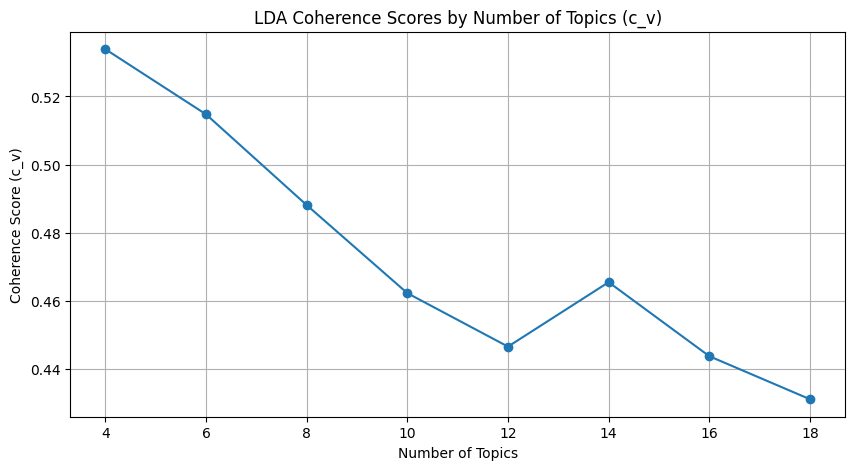

Optimal LDA Topics: 4


In [4]:
# Compute for k=4 to 20
k_range = range(4, 21, 2)
lda_coherence_values = compute_lda_coherence_values(corpus, dictionary, texts_sample, k_range)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(k_range, lda_coherence_values, marker='o')
plt.title('LDA Coherence Scores by Number of Topics (c_v)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_v)')
plt.grid(True)
plt.show()

# Optimal LDA topics (highest coherence, ignoring NaNs)
valid_scores = np.nan_to_num(lda_coherence_values, nan=-np.inf)
optimal_lda_topics = k_range[np.argmax(valid_scores)]
print(f"Optimal LDA Topics: {optimal_lda_topics}")

### b) 3.2 For NMF (using scikit-learn with Gensim coherence adapter)

In [5]:
def compute_nmf_coherence_values(tfidf_matrix, tfidf_features, texts, dictionary, k_range, coherence_type='c_v', topn=30):
    coherence_values = []
    
    for k in k_range:
        try:
            nmf_model = NMF(n_components=k, init='nndsvda', solver='cd', random_state=42, max_iter=400)
            W = nmf_model.fit_transform(tfidf_matrix)
            H = nmf_model.components_

            # Get top words per topic
            top_words = []
            for topic_idx, topic in enumerate(H):
                top_indices = np.argsort(topic)[::-1]
                topic_words = [tfidf_features[i] for i in top_indices[:topn]]
                top_words.append(topic_words)

            # Diagnostics
            word_counts = [len(tw) for tw in top_words]
            print(f"For k={k}, Word counts per topic: {word_counts}")

            coherence_model = CoherenceModel(
                topics=top_words,
                texts=texts,
                dictionary=dictionary,
                coherence=coherence_type
            )
            score = coherence_model.get_coherence()
            coherence_values.append(score)
            print(f"Num Topics: {k}, Coherence ({coherence_type}): {score}")

        except Exception as e:
            print(f"Error for k={k}: {e}")
            coherence_values.append(np.nan)

    return coherence_values

For k=4, Word counts per topic: [30, 30, 30, 30]
Num Topics: 4, Coherence (c_v): 0.3802579738282577
For k=6, Word counts per topic: [30, 30, 30, 30, 30, 30]
Num Topics: 6, Coherence (c_v): 0.410069387399323
For k=8, Word counts per topic: [30, 30, 30, 30, 30, 30, 30, 30]
Num Topics: 8, Coherence (c_v): 0.4106202260327028
For k=10, Word counts per topic: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Num Topics: 10, Coherence (c_v): 0.39910242074198216
For k=12, Word counts per topic: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Num Topics: 12, Coherence (c_v): 0.3993472716512334
For k=14, Word counts per topic: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Num Topics: 14, Coherence (c_v): 0.3858117870657313
For k=16, Word counts per topic: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Num Topics: 16, Coherence (c_v): 0.38344716962172254
For k=18, Word counts per topic: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Num Topics: 18, C

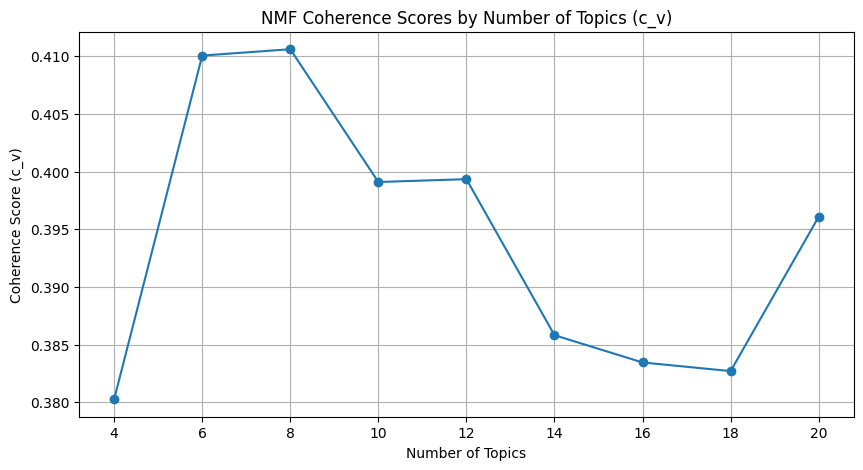

Optimal NMF Topics: 8


In [6]:
# Compute for same k_range 
nmf_coherence_values = compute_nmf_coherence_values(tfidf_matrix, tfidf_features, texts, dictionary, k_range)

# Plot NMF coherence scores
plt.figure(figsize=(10, 5))
plt.plot(k_range, nmf_coherence_values, marker='o')
plt.title('NMF Coherence Scores by Number of Topics (c_v)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_v)')
plt.grid(True)
plt.show()

# Optimal NMF topics (highest coherence, ignoring NaNs)
valid_scores = np.nan_to_num(nmf_coherence_values, nan=-np.inf)
optimal_nmf_topics = k_range[np.argmax(valid_scores)]
print(f"Optimal NMF Topics: {optimal_nmf_topics}")

## 4. Train Final Models with Optimal Topics

### a) LDA Model

In [7]:
# Train LDA with optimal topics
lda_model = LdaMulticore(corpus=corpus, num_topics=optimal_lda_topics, id2word=dictionary, passes=10, workers=4, random_state=42)

# Save model
lda_model.save('../data/processed/lda_model.gensim')

# Display top words per topic
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.104*"music" + 0.103*"loud" + 0.100*"party" + 0.100*"music party" + 0.100*"loud music" + 0.057*"hydrant" + 0.020*"noise" + 0.019*"non" + 0.015*"construction" + 0.013*"light"
Topic 1: 0.053*"violation" + 0.052*"sign" + 0.049*"post" + 0.049*"parking" + 0.049*"parking sign" + 0.049*"sign violation" + 0.049*"post parking" + 0.047*"bang pound" + 0.047*"pound" + 0.047*"bang"
Topic 2: 0.042*"plate" + 0.041*"use" + 0.041*"license" + 0.040*"license plate" + 0.021*"use comment" + 0.021*"comment" + 0.018*"permit" + 0.018*"flooding" + 0.018*"fall" + 0.017*"monitoring"
Topic 3: 0.184*"entire" + 0.036*"talk" + 0.036*"loud talk" + 0.035*"loud" + 0.021*"commercial" + 0.020*"overnight" + 0.020*"parking" + 0.020*"park" + 0.020*"double park" + 0.020*"double"


### b) NMF Model

In [8]:
# Train NMF with optimal topics
nmf_model = NMF(
    n_components=optimal_nmf_topics,
    init='nndsvda',
    solver='cd',
    random_state=42,
    max_iter=400
)
W_nmf = nmf_model.fit_transform(tfidf_matrix)
H_nmf = nmf_model.components_

# Save model
joblib.dump(nmf_model, '../data/processed/nmf_model.pkl')

# Display top words per topic (top 30)
for topic_idx, topic in enumerate(H_nmf):
    top_words = [tfidf_features[i] for i in topic.argsort()[:-31:-1]]
    print(f"Topic {topic_idx}: {' '.join(top_words)}")

Topic 0: entire entire tree tree fall fall tree branch limb branch limb limb fall program tree sidewalk sidewalk program crack fall branch crack crack uproot leaning leaning uproot tree leaning dead branch branch tree dead alive poor alive poor condition poor tree alive unauthorized tree tree removal danger fall
Topic 1: loud music music party party music loud truck music car truck car truck television loud television truck horn horn engine music boat engine music etc noise boat boat etc engine noise food delivery third party delivery delivery service third party food route violation truck route route
Topic 2: hydrant hydrant run run hydrant leak leak hydrant defective defective run full full hydrant knock knock missing knock missing cin hydrant cin use hydrant illegal use use illegal leak use use comment comment side post hydrant side post whfp side installation installation hydrant whfp defective hardware
Topic 3: bang pound pound bang partial access access partial overnight commerci

## 5. Evaluation

In [9]:
# Final coherence for LDA (c_v, using sample)
lda_coherence = CoherenceModel(model=lda_model, texts=texts_sample, dictionary=dictionary, coherence='c_v').get_coherence()
print(f"Final LDA Coherence (c_v): {lda_coherence}")

# Final coherence for NMF (c_v, using full texts)
nmf_top_words = [[tfidf_features[i] for i in topic.argsort()[:-31:-1]] for topic in H_nmf]
nmf_coherence = CoherenceModel(topics=nmf_top_words, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
print(f"Final NMF Coherence (c_v): {nmf_coherence}")

Final LDA Coherence (c_v): 0.5383679627932139
Final NMF Coherence (c_v): 0.4106202260327028


## 6. Visualization

### a) pyLDAvis for LDA

In [13]:
# Prepare and display visualization
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

In [14]:
# Save to HTML for reference
pyLDAvis.save_html(vis_data, '../data/processed/lda_visualization.html')

### b) Word Clouds for NMF Topics

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


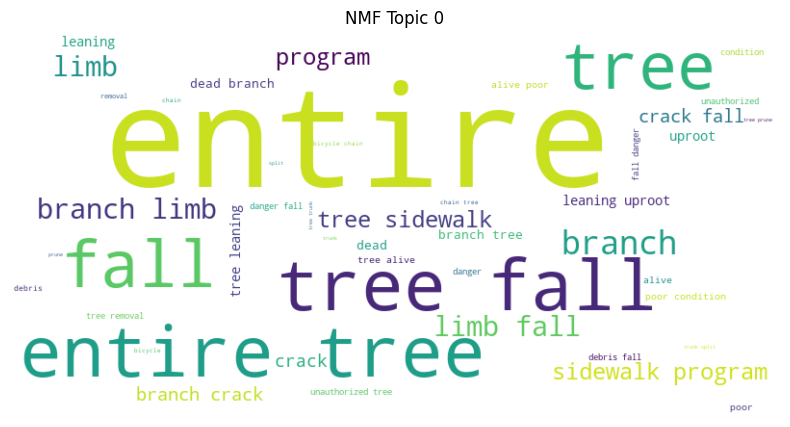

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


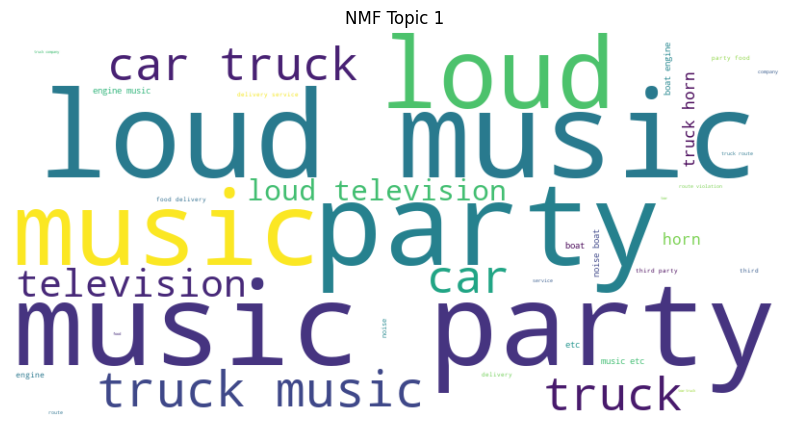

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


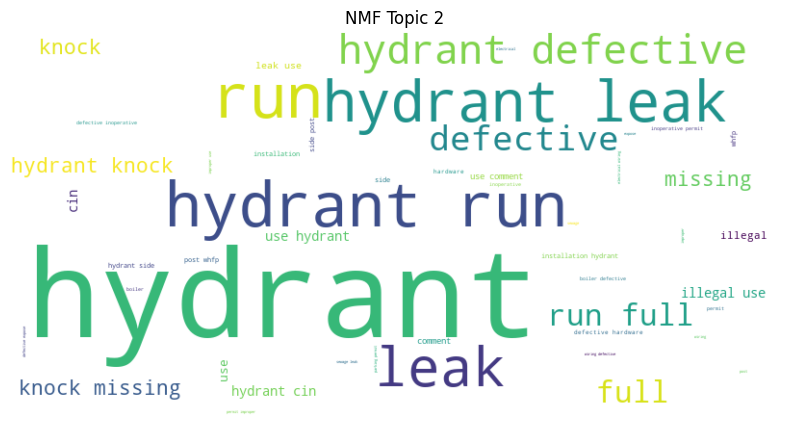

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


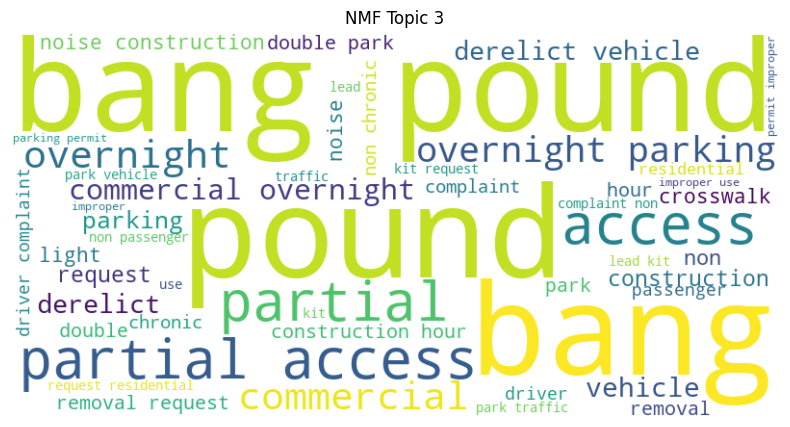

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


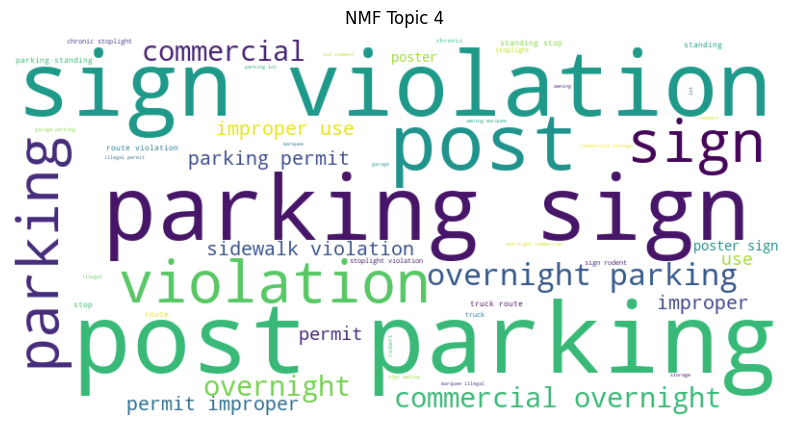

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


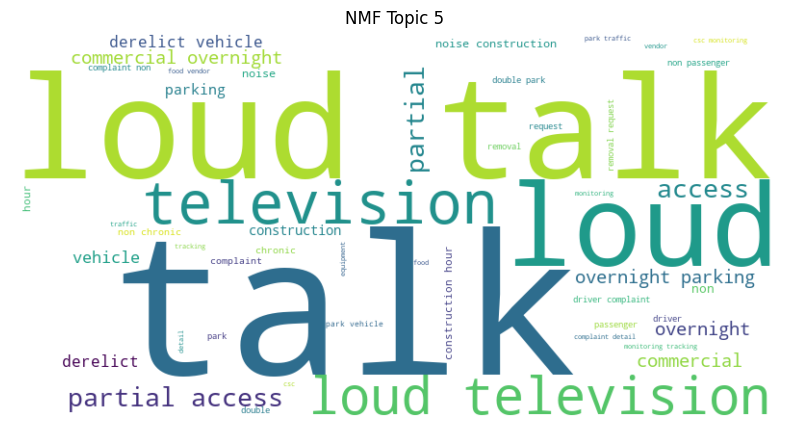

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


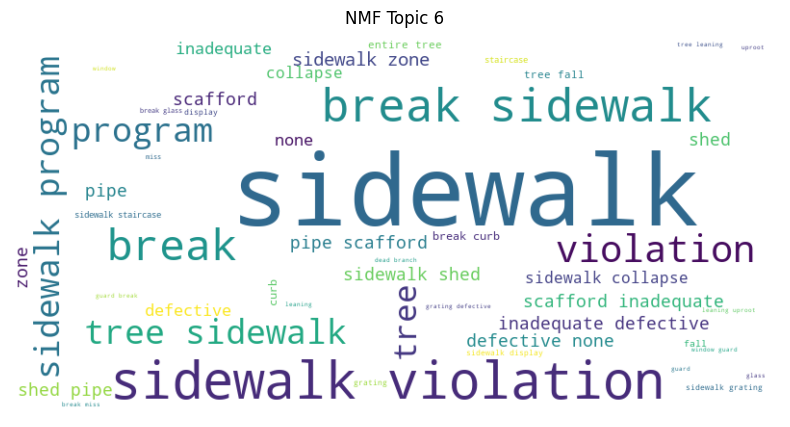

C:\Users\quadr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


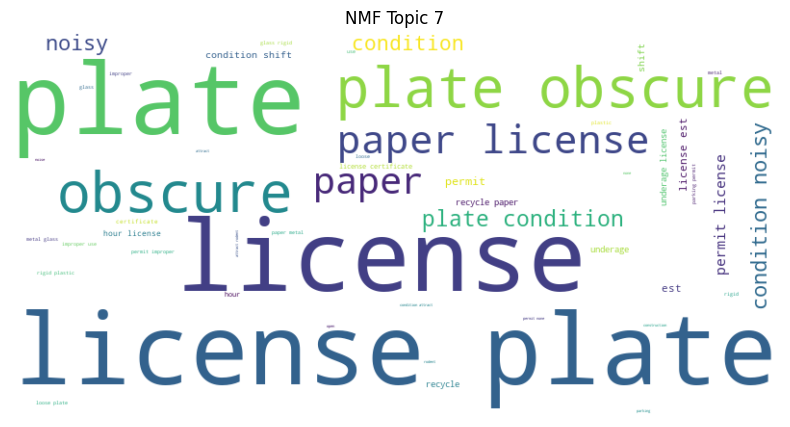

In [11]:
# Generate word clouds for each NMF topic
for topic_idx, topic in enumerate(H_nmf):
    word_weights = {tfidf_features[i]: topic[i] for i in topic.argsort()[:-51:-1]}  # Top 50 for cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'NMF Topic {topic_idx}')
    plt.show()

## 7. Quantitative Comparison

In [16]:
# Topic Similarity (Cosine between topic-word vectors)
# Get LDA topic-word matrix (probabilities)
lda_topic_words = np.array([lda_model.get_topic_terms(i, topn=len(dictionary)) for i in range(lda_model.num_topics)])
lda_matrix = np.zeros((lda_model.num_topics, len(dictionary)))
for t in range(lda_model.num_topics):
    for word_id, prob in lda_model.get_topic_terms(t, topn=len(dictionary)):
        lda_matrix[t, word_id] = prob

In [17]:
# Normalize to probabilities
nmf_matrix = H_nmf / H_nmf.sum(axis=1, keepdims=True)

In [19]:
# If num_topics differ, compare pairwise (or pad smaller)
if lda_matrix.shape[0] != nmf_matrix.shape[0]:
    print("Num topics differ; computing average pairwise similarity.")
    similarities = cosine_similarity(lda_matrix, nmf_matrix)
    avg_sim = np.mean(similarities)
else:
    similarities = cosine_similarity(lda_matrix, nmf_matrix)
    avg_sim = np.mean(np.diag(similarities))  # Diagonal for matched topics

print(f"Average Topic Similarity (LDA vs NMF): {avg_sim}")

Num topics differ; computing average pairwise similarity.
Average Topic Similarity (LDA vs NMF): 0.15068945812248202


In [20]:
# Document-Topic Overlap (Jaccard on top topics per doc)
lda_doc_topics = [max(lda_model.get_document_topics(doc, minimum_probability=0), key=lambda x: x[1])[0] for doc in corpus[:10000]]  # Sample 10k
nmf_doc_topics = np.argmax(W_nmf[:10000], axis=1)  # From NMF document-topic matrix
jaccard = len(set(lda_doc_topics) & set(nmf_doc_topics)) / len(set(lda_doc_topics) | set(nmf_doc_topics))
print(f"Document-Topic Overlap (Jaccard): {jaccard}")  # Higher = better agreement

Document-Topic Overlap (Jaccard): 0.5


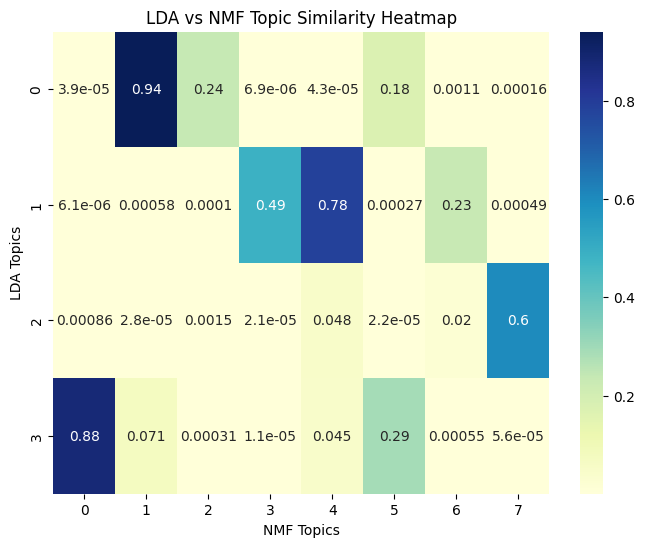

In [21]:
# Visualize Comparison (Heatmap of similarities)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(similarities, annot=True, cmap='YlGnBu')
plt.title('LDA vs NMF Topic Similarity Heatmap')
plt.xlabel('NMF Topics')
plt.ylabel('LDA Topics')
plt.show()